# Import libs

In [52]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import cv2
import PIL.Image as Image
import PIL

import pathlib
import matplotlib.pyplot as plt

# Load Trained MobileNetV2 model
Load the model and perform a sample prediction

In [14]:
IMAGE_SHAPE = (224,224)

classifier = keras.Sequential([
    hub.KerasLayer("model", input_shape=IMAGE_SHAPE+(3,))
])

In [19]:
goldfish_img = Image.open("goldfish.jpg").resize(IMAGE_SHAPE)

In [21]:
goldfish_img = np.array(goldfish_img) / 255.0
goldfish_img.shape

(224, 224, 3)

In [22]:
goldfish_img[np.newaxis, ...].shape

(1, 224, 224, 3)

In [31]:
result = classifier.predict(goldfish_img[np.newaxis, ...])
result = result[0]
result

array([ 0.2210783 ,  2.0497668 ,  9.622809  , ..., -1.4619296 ,
       -0.2823091 , -0.25916258], dtype=float32)

In [25]:
with open("class_labels.txt", "r") as f:
    class_labels = f.read().splitlines()
    
class_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [33]:
class_labels[np.argmax(result)]

'goldfish'

# Load Dataset
Download Flowers dataset from Googleapis

In [34]:
dataset_url ="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file("flower_photos", 
                                   origin=dataset_url,
                                   cache_dir=".",
                                   untar=True)

# Proprocess
<ol>
    <li>Use pathlib to convert paths to OS objects</li>
    <li>Build dictionaries for images path, labels </li>
    <li>Resize the images to resolution (180,180) </li>
    <li>Convert X,y to numpy array</li>
    <li>Split the data into train , test</li>
    <li>Scale the X dataset</li>
</ol>

In [38]:
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('datasets/flower_photos')

In [39]:
roses = list(data_dir.glob('roses/*'))

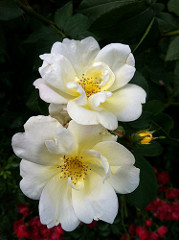

In [43]:
Image.open(roses[0])

In [44]:
flowers_path_dict = {
    'roses' : list(data_dir.glob('roses/*')),
    'daisy' : list(data_dir.glob('daisy/*')),
    'dandelion' : list(data_dir.glob('dandelion/*')),
    'sunflowers' : list(data_dir.glob('sunflowers/*')),
    'tulips' : list(data_dir.glob('tulips/*')),    
}

In [45]:
flowers_indices_dict = {
    'roses' : 0,
    'daisy' : 1,
    'dandelion' : 2,
    'sunflowers' : 3,
    'tulips' : 4, 
}

In [46]:
flowers_labels_dict = {
    0 : 'roses' ,
    1 : 'daisy',
    2 : 'dandelion',
    3 : 'sunflowers',
    4 : 'tulips'
}

In [64]:
X , y = [] , []

for flower,image_paths in flowers_path_dict.items() :
    for image_path in image_paths:
        img = cv2.imread(str(image_path))
        img = cv2.resize(img, IMAGE_SHAPE)
        
        X.append(img)
        y.append(flowers_indices_dict[flower])

In [65]:
X = np.array(X)
y = np.array(y)

In [66]:
X_train , X_test , y_train , y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [67]:
X_train.shape

(2936, 224, 224, 3)

In [68]:
y_train.shape

(2936,)

In [69]:
X_test.shape

(734, 224, 224, 3)

In [70]:
y_test.shape

(734,)

In [71]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [72]:
X_train = np.array(X_train)
X_test = np.array(X_test)

# Model - Predict

In [86]:
y_pred = classifier.predict(X_test[:5])
y_pred

array([[ 0.19811264,  0.71709096,  0.9482728 , ...,  2.3869116 ,
         0.6111816 ,  0.2301744 ],
       [ 0.31764635, -0.8654659 ,  1.1410033 , ..., -0.7889879 ,
         0.5925194 , -0.41774255],
       [ 0.17862126, -1.6821953 ,  0.28524756, ..., -0.34590122,
        -0.64890033, -1.0288646 ],
       [ 0.05278879, -0.4982677 ,  1.685448  , ..., -0.8594339 ,
         0.5057685 ,  1.1687449 ],
       [ 0.20092061, -1.5516831 ,  0.7329958 , ..., -0.4016112 ,
        -0.6043179 ,  0.6618519 ]], dtype=float32)

In [87]:
y_pred = [np.argmax(i) for i in y_pred]
y_pred

[724, 109, 707, 986, 986]

In [88]:
y_pred_labels = [class_labels[i] for i in y_pred]
y_pred_labels

['pinwheel', 'sea anemone', 'patio', 'daisy', 'daisy']

Text(0.5, 0, 'pinwheel')

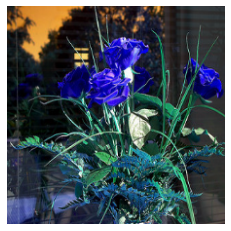

In [89]:
plt.axis('off')
plt.imshow(X_test[0])
plt.xlabel(y_pred_labels[0])

# Retrain / Transfer Learn a new Model
Freeze the MobileNetV2's hidden layers <br>
Train only the output layer with softmax for 5 classes

In [90]:
feature_vector = hub.KerasLayer("mobilenetv2_feature_vector", 
                                 input_shape=IMAGE_SHAPE+(3,), 
                                 trainable=False)

In [92]:
retrained_model = keras.Sequential([
    feature_vector,
    keras.layers.Dense(5, activation="softmax")
])

retrained_model.compile(optimizer="adam",
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy'])

retrained_model.fit(X_train, y_train, epochs=5)

Epoch 1/5
92/92 [==============================] - 75s 775ms/step - loss: 0.8176 - accuracy: 0.7057
Epoch 2/5
92/92 [==============================] - 72s 778ms/step - loss: 0.4138 - accuracy: 0.8678
Epoch 3/5
92/92 [==============================] - 76s 833ms/step - loss: 0.3262 - accuracy: 0.8900
Epoch 4/5
92/92 [==============================] - 76s 827ms/step - loss: 0.2734 - accuracy: 0.9183
Epoch 5/5
92/92 [==============================] - 80s 871ms/step - loss: 0.2333 - accuracy: 0.9322


In [93]:
retrained_model.evaluate(X_test, y_test)

C:\Users\I301903\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


23/23 [==============================] - 17s 688ms/step - loss: 0.3315 - accuracy: 0.8760


[0.33149954676628113, 0.8760218024253845]

In [94]:
y_pred = retrained_model.predict(X_test)
y_pred[0:5]

array([[6.7383152e-01, 9.3435347e-02, 5.0899400e-03, 1.9119875e-01,
        3.6444508e-02],
       [2.9905313e-03, 5.3676125e-02, 1.1904564e-01, 8.2237071e-01,
        1.9170252e-03],
       [2.9146178e-03, 2.4886552e-04, 4.8342836e-03, 3.8812456e-03,
        9.8812103e-01],
       [1.6453391e-03, 9.7092789e-01, 6.4144554e-03, 1.0757672e-02,
        1.0254617e-02],
       [1.3467247e-04, 9.8834628e-01, 2.2129789e-03, 8.8035036e-03,
        5.0248014e-04]], dtype=float32)

In [95]:
y_pred = [np.argmax(i) for i in y_pred]
y_pred[:5]

[0, 3, 4, 1, 1]

In [96]:
y_test[:5]

array([0, 3, 4, 1, 1])

Text(0, 0.5, 'sunflowers')

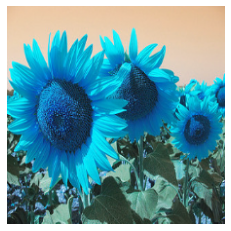

In [98]:
i=100

plt.axis("off")
plt.imshow(X_test[i])
plt.ylabel(flowers_labels_dict[y_pred[i]])

Text(0, 0.5, 'dandelion')

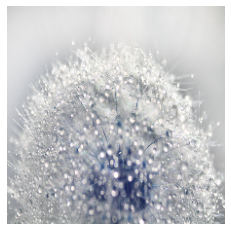

In [97]:
i=300

plt.axis("off")
plt.imshow(X_test[i])
plt.ylabel(flowers_labels_dict[y_pred[i]])

In [100]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88       156
           1       0.86      0.84      0.85       128
           2       0.90      0.89      0.90       174
           3       0.86      0.91      0.88       122
           4       0.86      0.88      0.87       154

    accuracy                           0.88       734
   macro avg       0.87      0.88      0.87       734
weighted avg       0.88      0.88      0.88       734

